# Stock Price Prediction with GRU Neural Network
This notebook demonstrates the process of building a stock price prediction model using GRU (Gated Recurrent Unit) neural networks. We'll use historical stock data to predict future stock prices.

## Steps:
1. Import libraries and set up the environment
2. Fetch historical stock data
3. Calculate technical indicators
4. Preprocess data for the neural network
5. Build and train the GRU model
6. Evaluate model performance
7. Make predictions for future days

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Dict, List, Any, Tuple, Optional
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os
import traceback
import logging
import math

In [6]:
# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Configure logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger("stock_model")

# Check if MPS (Metal Performance Shaders) is available for M-series chips
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")


Using device: mps


## GRU Model Architecture
Define the GRU (Gated Recurrent Unit) neural network architecture.

In [7]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_dim, hidden_dim, num_layers, 
            batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

## Data Pipeline
Create a pipeline for fetching stock data, calculating technical indicators, and preprocessing.

In [19]:
class DataPipeline:
    def __init__(self):
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.feature_columns = None
        
    def fetch_stock_data(self, ticker: str, period: str = "1y") -> pd.DataFrame:
        """Fetch historical stock data"""
        try:
            logger.info(f"Fetching data for {ticker} with period {period}")
            stock_data = yf.download(ticker, period=period)
            if stock_data.empty:
                raise ValueError(f"No data found for ticker {ticker}")
            logger.info(f"Successfully fetched {len(stock_data)} rows for {ticker}")
            return stock_data
        except Exception as e:
            logger.error(f"Error fetching data for {ticker}: {str(e)}")
            traceback.print_exc()
            raise Exception(f"Error fetching data for {ticker}: {str(e)}")
    
    def calculate_technical_indicators(self, data: pd.DataFrame) -> pd.DataFrame:
        """Calculate technical indicators for feature engineering"""
        try:
            logger.info("Calculating technical indicators")
            df = data.copy()
            
            # Simple Moving Averages (SMA)
            df['SMA_5'] = df['Close'].rolling(window=5).mean()
            df['SMA_20'] = df['Close'].rolling(window=20).mean()
            
            # Price to SMA ratios - Fix for multi-column issue
            # Check if Close is a Series or DataFrame column
            if isinstance(df['Close'], pd.Series):
                df['Price_to_SMA_5'] = df['Close'] / df['SMA_5']
                df['Price_to_SMA_20'] = df['Close'] / df['SMA_20']
            else:
                # Handle multi-column case by selecting the specific column
                close_col = df['Close'].iloc[:, 0] if isinstance(df['Close'], pd.DataFrame) else df['Close']
                sma5_col = df['SMA_5'].iloc[:, 0] if isinstance(df['SMA_5'], pd.DataFrame) else df['SMA_5']
                sma20_col = df['SMA_20'].iloc[:, 0] if isinstance(df['SMA_20'], pd.DataFrame) else df['SMA_20']
                
                df['Price_to_SMA_5'] = close_col / sma5_col
                df['Price_to_SMA_20'] = close_col / sma20_col
            
            # Bollinger Bands
            df['BB_Middle'] = df['Close'].rolling(window=20).mean()
            df['BB_Std'] = df['Close'].rolling(window=20).std()
            df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_Std']
            df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_Std']
            df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle']
            
            # Relative Strength Index (RSI)
            delta = df['Close'].diff()
            gain = delta.where(delta > 0, 0)
            loss = -delta.where(delta < 0, 0)
            
            avg_gain = gain.rolling(window=14).mean()
            avg_loss = loss.rolling(window=14).mean()
            
            # Handle division by zero
            avg_loss = avg_loss.replace(0, np.nan)
            rs = avg_gain / avg_loss
            rs = rs.fillna(0)
            df['RSI'] = 100 - (100 / (1 + rs))
            
            # MACD (Moving Average Convergence Divergence)
            df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
            df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
            df['MACD'] = df['EMA_12'] - df['EMA_26']
            df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
            df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
            
            # Add day of week feature (0 = Monday, 6 = Sunday)
            df['DayOfWeek'] = df.index.dayofweek
            
            # Daily Returns
            df['Daily_Return'] = df['Close'].pct_change()
            
            # Volatility (standard deviation of returns over a window)
            df['Volatility'] = df['Daily_Return'].rolling(window=21).std()
            
            logger.info("Technical indicators calculated successfully")
            return df
        except Exception as e:
            logger.error(f"Error calculating technical indicators: {str(e)}")
            traceback.print_exc()
            raise Exception(f"Error calculating technical indicators: {str(e)}")
    
    def preprocess_data(self, data: pd.DataFrame) -> Tuple[np.ndarray, pd.DataFrame]:
        """Preprocess the stock data with technical indicators"""
        try:
            logger.info("Preprocessing data")
            # Calculate technical indicators
            data_with_indicators = self.calculate_technical_indicators(data)
            
            # Handle missing values created by indicators that use lookback periods
            data_with_indicators = data_with_indicators.bfill().ffill()
            
            # Select features for the model
            feature_columns = [
                'Open', 'High', 'Low', 'Close', 'Volume',
                'SMA_5', 'SMA_20', 'RSI', 'MACD', 'BB_Width',
                'Volatility', 'Daily_Return'
            ]
            
            # Ensure all selected features exist
            available_features = [col for col in feature_columns if col in data_with_indicators.columns]
            logger.info(f"Using features: {available_features}")
            
            # Store feature columns for later use
            self.feature_columns = available_features
            
            # Get the processed data with selected features
            processed_data = data_with_indicators[available_features].copy()
            
            # Store the column indices for reference
            self.column_indices = {col: i for i, col in enumerate(processed_data.columns)}
            self.close_idx = self.column_indices.get('Close', 3)  # Default to 3 if not found
            logger.info(f"Close price index: {self.close_idx}")
            
            # Feature scaling
            scaled_data = self.scaler.fit_transform(processed_data)
            logger.info("Data preprocessing completed successfully")
            
            return scaled_data, processed_data
        except Exception as e:
            logger.error(f"Error preprocessing data: {str(e)}")
            traceback.print_exc()
            raise Exception(f"Error preprocessing data: {str(e)}")
    
    def create_sequences(self, data: np.ndarray, window_size: int) -> Tuple[np.ndarray, np.ndarray]:
        """Create input sequences for the model"""
        try:
            X, y = [], []
            for i in range(len(data) - window_size):
                X.append(data[i:i+window_size])
                y.append(data[i+window_size, self.close_idx])  # Use the stored close index
                
            return np.array(X), np.array(y)
        except Exception as e:
            logger.error(f"Error creating sequences: {str(e)}")
            traceback.print_exc()
            raise Exception(f"Error creating sequences: {str(e)}")
    
    def inverse_transform_price(self, scaled_price: float, original_data: pd.DataFrame) -> float:
        """Convert scaled price back to the original scale"""
        try:
            # Create a dummy array with the same shape as the original data
            dummy = np.zeros((1, len(self.feature_columns)))
            dummy[0, self.close_idx] = scaled_price  # Use the stored close index
            
            # Inverse transform and extract the Close price
            return self.scaler.inverse_transform(dummy)[0, self.close_idx]
        except Exception as e:
            logger.error(f"Error inverse transforming price: {str(e)}")
            traceback.print_exc()
            raise Exception(f"Error inverse transforming price: {str(e)}")


## Fetch Historical Stock Data and Preprocess
Let's fetch historical data for a selected stock and preprocess it for our model.

2025-03-02 03:04:03,454 - stock_model - INFO - Fetching data for AAPL with period 2y
[*********************100%***********************]  1 of 1 completed
2025-03-02 03:04:04,191 - stock_model - INFO - Successfully fetched 502 rows for AAPL


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2023-03-01,143.859222,145.760051,143.562215,145.364051,55479000
2023-03-02,144.453232,145.245248,142.463290,142.938509,52238100
2023-03-03,149.522110,149.601313,145.859054,146.561957,70732300
2023-03-06,152.294174,154.739515,151.927873,152.254565,87558000
2023-03-07,150.086426,152.492157,149.621117,152.165450,56182000


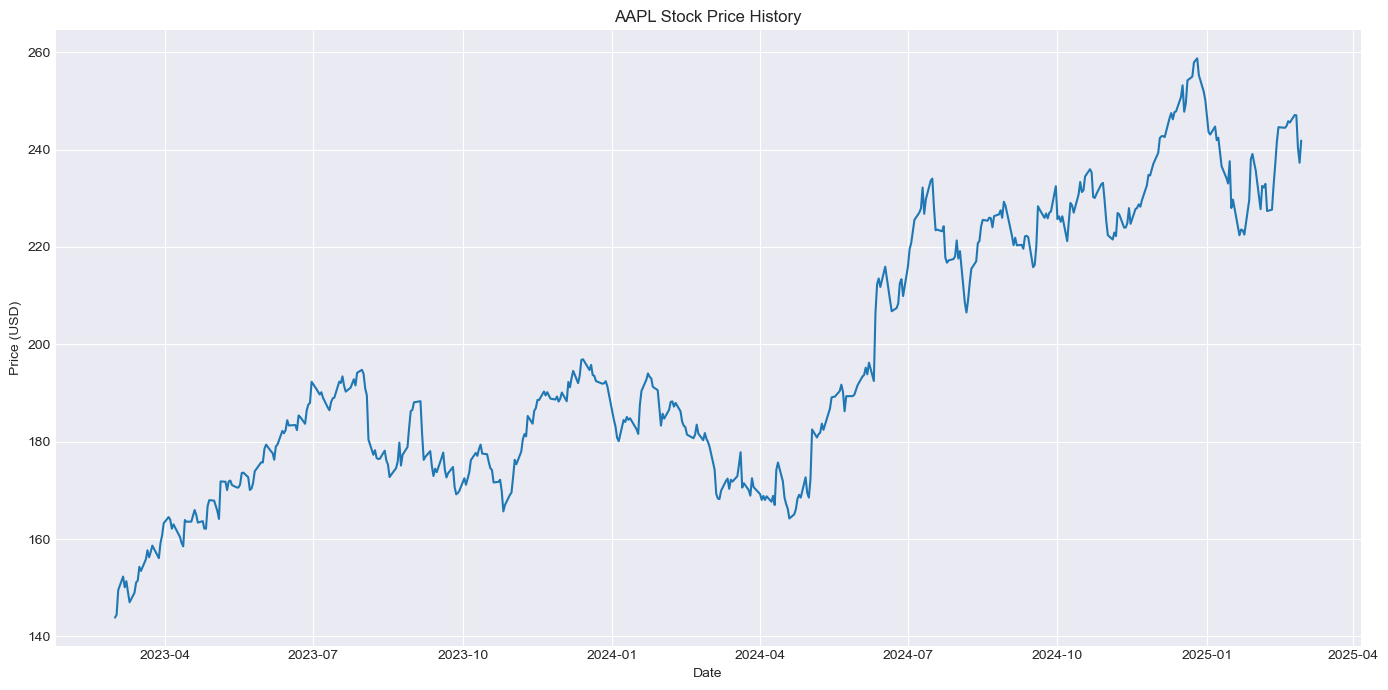

2025-03-02 03:04:04,363 - stock_model - INFO - Preprocessing data
2025-03-02 03:04:04,363 - stock_model - INFO - Calculating technical indicators
2025-03-02 03:04:04,384 - stock_model - INFO - Technical indicators calculated successfully
2025-03-02 03:04:04,387 - stock_model - INFO - Using features: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_20', 'RSI', 'MACD', 'BB_Width', 'Volatility', 'Daily_Return']
2025-03-02 03:04:04,390 - stock_model - INFO - Close price index: 3
2025-03-02 03:04:04,403 - stock_model - INFO - Data preprocessing completed successfully


Price,Open,High,Low,Close,Volume,SMA_5,SMA_20,RSI,MACD,BB_Width,Volatility,Daily_Return
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,
Date,,,,,,,,,,,,
2023-03-01,145.364051,145.760051,143.562215,143.859222,55479000,148.043033,152.272372,0.0,0.000000,0.114297,0.013562,0.004129
2023-03-02,142.938509,145.245248,142.463290,144.453232,52238100,148.043033,152.272372,0.0,0.047385,0.114297,0.013562,0.004129
2023-03-03,146.561957,149.601313,145.859054,149.522110,70732300,148.043033,152.272372,0.0,0.488326,0.114297,0.013562,0.035090
2023-03-06,152.254565,154.739515,151.927873,152.294174,87558000,148.043033,152.272372,0.0,1.049360,0.114297,0.013562,0.018539
2023-03-07,152.165450,152.492157,149.621117,150.086426,56182000,148.043033,152.272372,0.0,1.300842,0.114297,0.013562,-0.014497


In [20]:
# Initialize the data pipeline
pipeline = DataPipeline()

# Choose stock ticker and period
ticker = 'AAPL'  # Apple Inc. - you can change this to any stock ticker
period = '2y'    # 2 years of historical data

# Fetch stock data
stock_data = pipeline.fetch_stock_data(ticker, period)

# Display the first few rows
display(stock_data.head())

# Plot historical prices
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index, stock_data['Close'])
plt.title(f'{ticker} Stock Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Preprocess data
scaled_data, original_data = pipeline.preprocess_data(stock_data)

# Show the features being used
display(original_data.head())

## Visualize Technical Indicators
Let's visualize some of the technical indicators to understand how they correlate with stock prices.

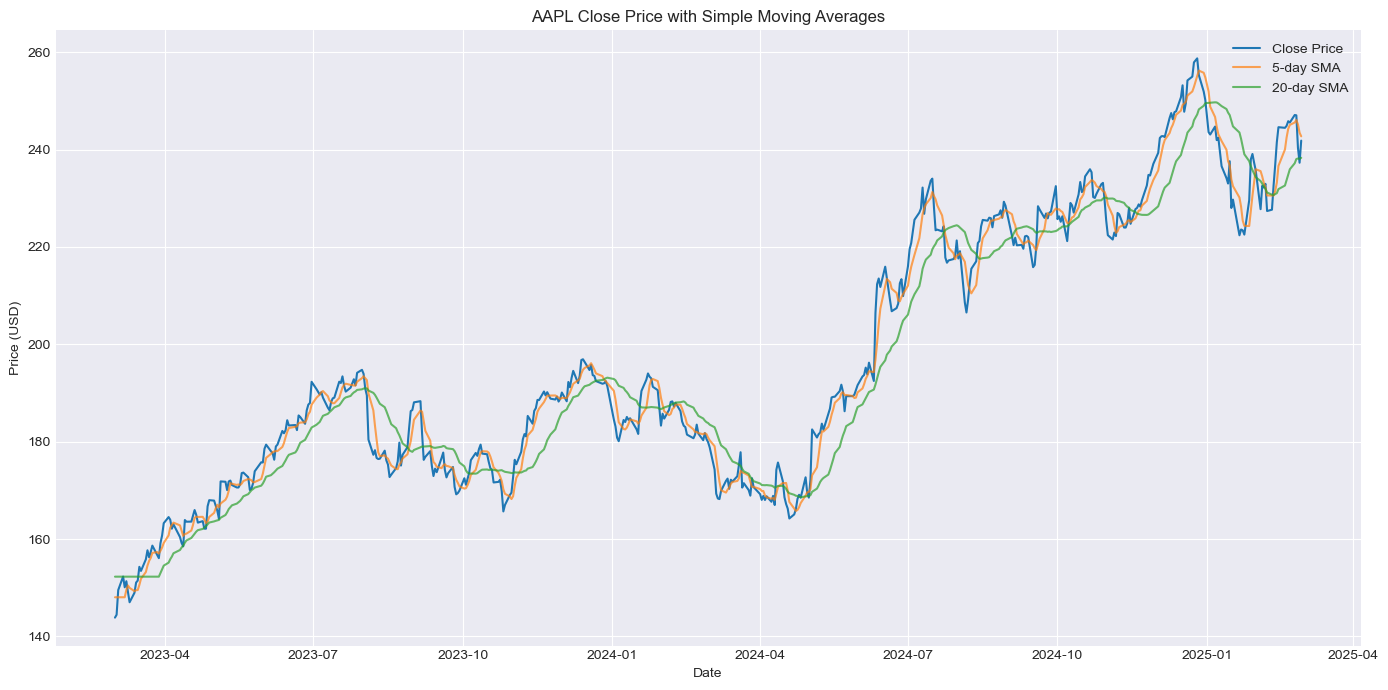

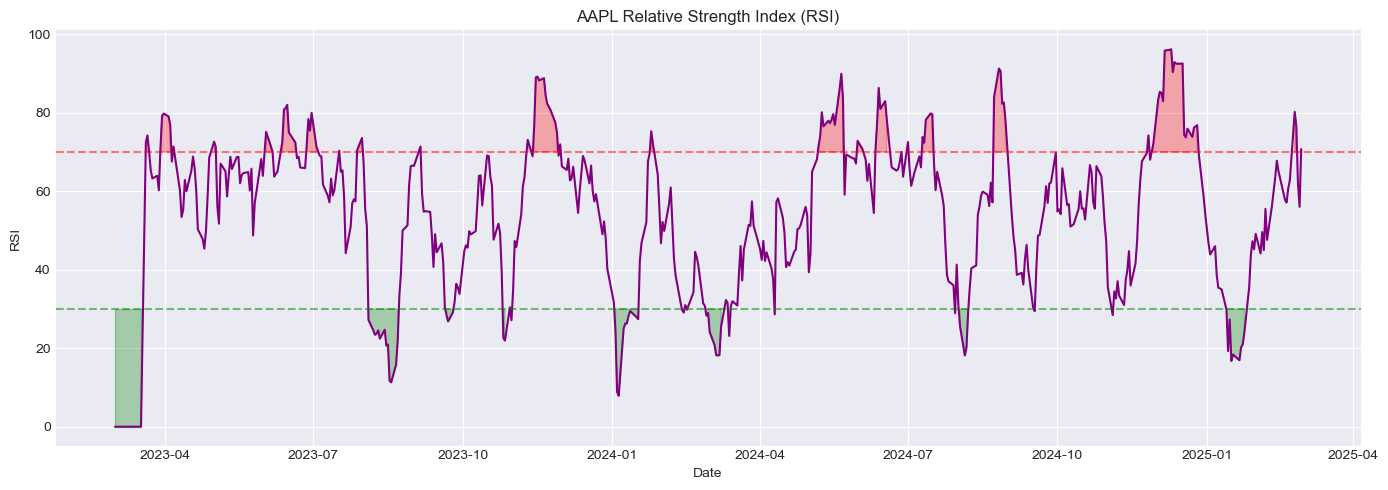

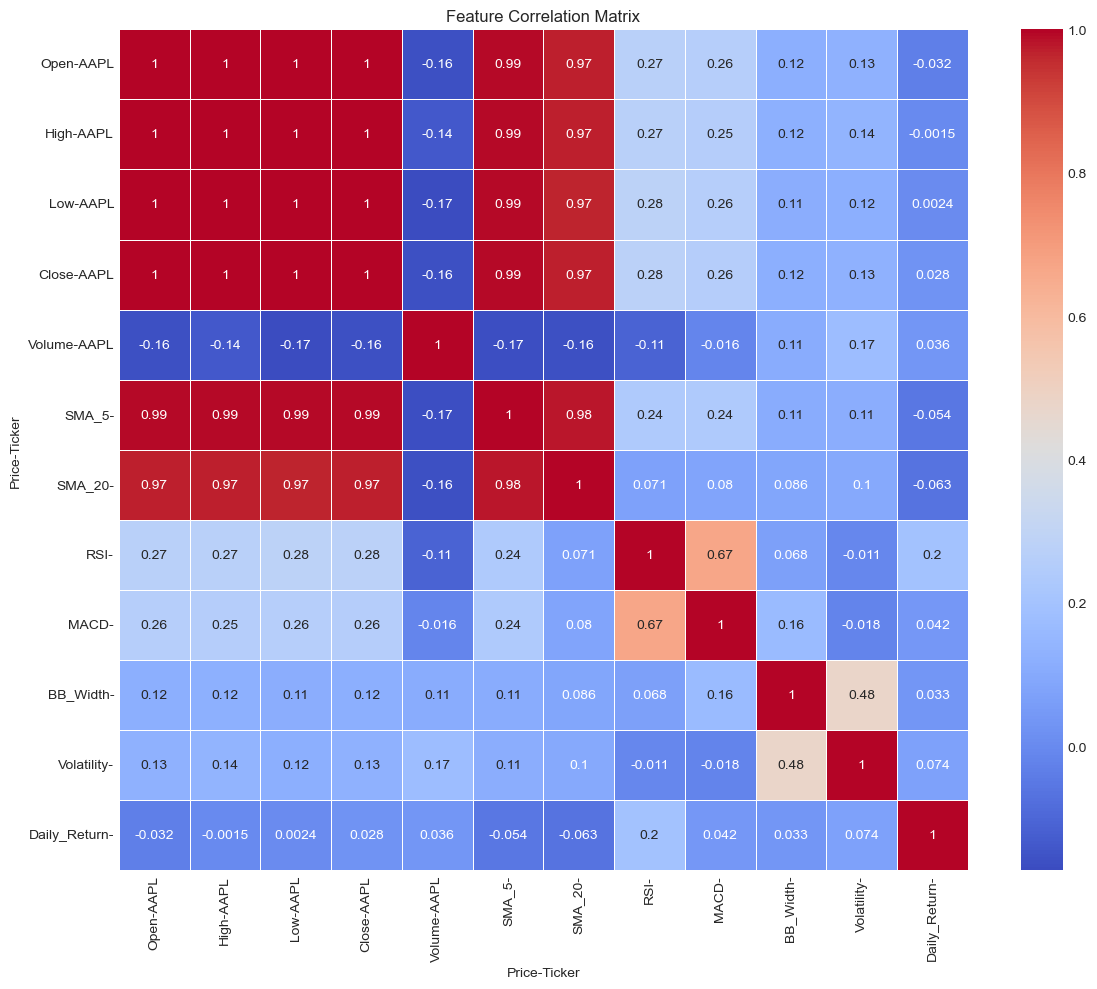

In [21]:
# Plot Close price with SMA
plt.figure(figsize=(14, 7))
plt.plot(original_data.index, original_data['Close'], label='Close Price')
plt.plot(original_data.index, original_data['SMA_5'], label='5-day SMA', alpha=0.7)
plt.plot(original_data.index, original_data['SMA_20'], label='20-day SMA', alpha=0.7)
plt.title(f'{ticker} Close Price with Simple Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot RSI
plt.figure(figsize=(14, 5))
plt.plot(original_data.index, original_data['RSI'], color='purple')
plt.axhline(y=70, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=30, color='g', linestyle='--', alpha=0.5)
plt.title(f'{ticker} Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.fill_between(original_data.index, original_data['RSI'], 70, where=(original_data['RSI'] >= 70), color='red', alpha=0.3)
plt.fill_between(original_data.index, original_data['RSI'], 30, where=(original_data['RSI'] <= 30), color='green', alpha=0.3)
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation matrix of features
plt.figure(figsize=(12, 10))
correlation = original_data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Create Sequences and Split Data
Prepare the data for training by creating sequences and splitting into training and testing sets.

In [22]:
# Window size for sequences
window_size = 20  # Use 20 days of data to predict the next day

# Create sequences
X, y = pipeline.create_sequences(scaled_data, window_size)

print(f"X shape: {X.shape}, y shape: {y.shape}")

# Split the data into training and testing sets
train_ratio = 0.8  # 80% for training, 20% for testing
split_idx = int(len(X) * train_ratio)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training data: {X_train.shape}")
print(f"Testing data: {X_test.shape}")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)


X shape: (482, 20, 12), y shape: (482,)
Training data: (385, 20, 12)
Testing data: (97, 20, 12)


## Build and Train the GRU Model
Now let's build our GRU model and train it with the prepared data.

GRUModel(
  (gru): GRU(12, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch [10/100], Train Loss: 0.001543, Val Loss: 0.001888
Epoch [20/100], Train Loss: 0.001066, Val Loss: 0.003329
Epoch [30/100], Train Loss: 0.001698, Val Loss: 0.005195
Epoch [40/100], Train Loss: 0.000855, Val Loss: 0.001375
Epoch [50/100], Train Loss: 0.000838, Val Loss: 0.002835
Early stopping at epoch 54


/var/folders/m4/zw00zs7x0m7chsqwc4kb_lkr0000gn/T/ipykernel_16275/3526050187.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model

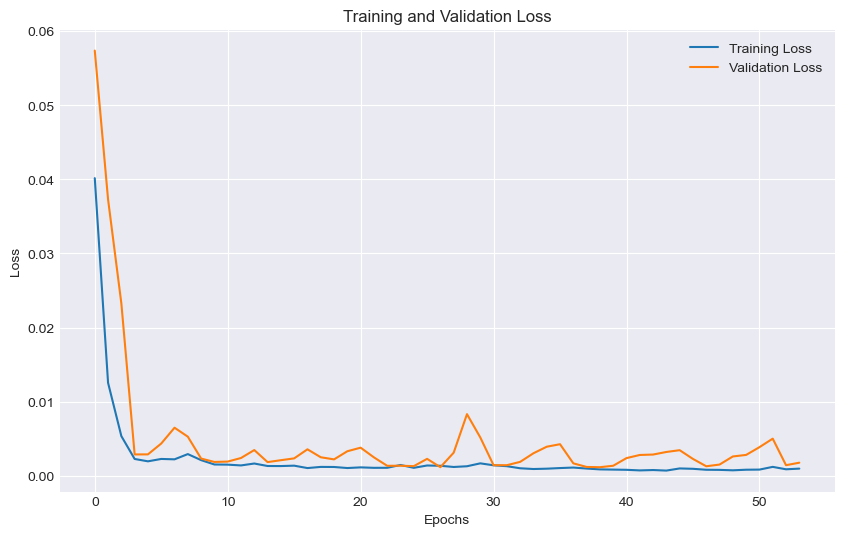

In [23]:
# Model parameters
input_dim = X_train.shape[2]  # Number of features
hidden_dim = 64
num_layers = 2
output_dim = 1
dropout = 0.2

# Create the model
model = GRUModel(input_dim, hidden_dim, num_layers, output_dim, dropout).to(device)
print(model)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 100
batch_size = 32

# Training loop
train_losses = []
val_losses = []

# For early stopping
best_val_loss = float('inf')
patience = 15
counter = 0

# Create data loader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Calculate average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation
Let's evaluate our model's performance on the test set.

Mean Squared Error: 15.5298
Root Mean Squared Error: 3.9408
Mean Absolute Error: 3.1203
R² Score: 0.8252


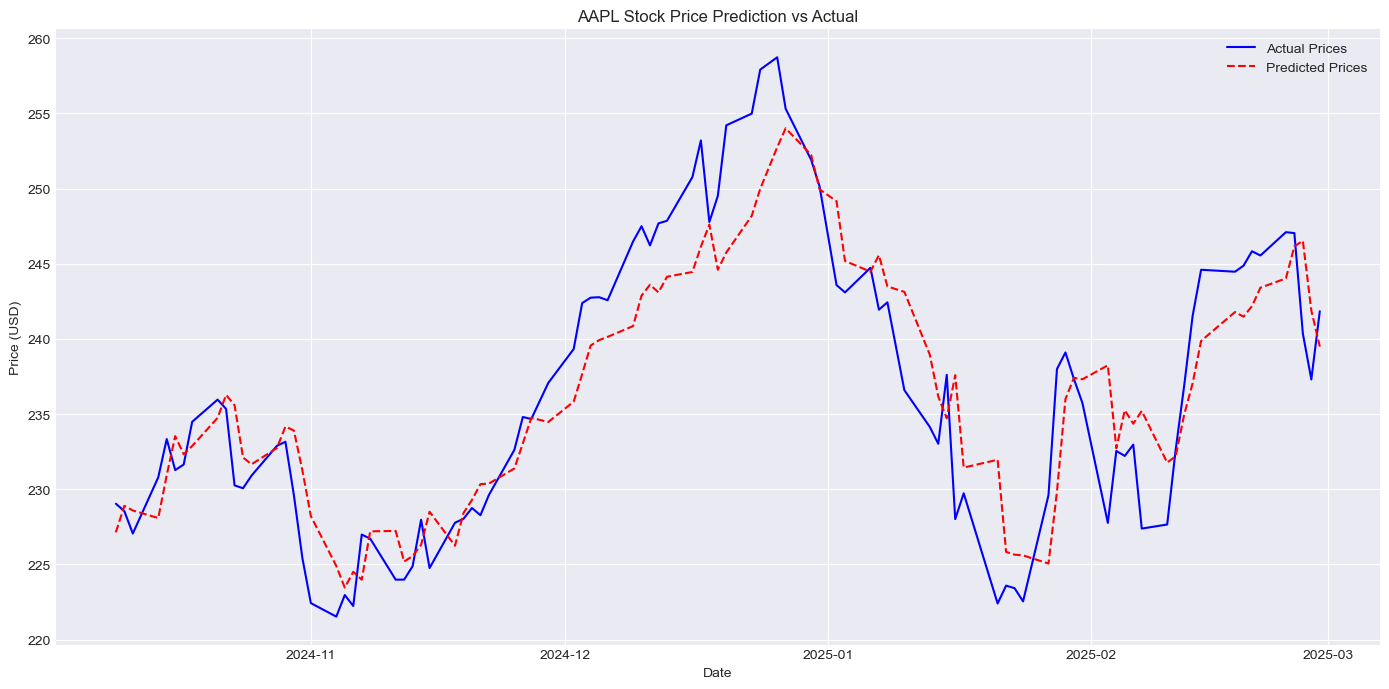

In [24]:
# Make predictions on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()

# Inverse transform the predictions and actual values
y_test_inv = np.array([pipeline.inverse_transform_price(val, original_data) for val in y_test])
y_pred_inv = np.array([pipeline.inverse_transform_price(val[0], original_data) for val in y_pred])

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R² Score: {r2:.4f}')

# Visualize predictions vs actual values
test_dates = original_data.index[window_size+split_idx:window_size+len(y_test)+split_idx]

plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_inv, label='Actual Prices', color='blue')
plt.plot(test_dates, y_pred_inv, label='Predicted Prices', color='red', linestyle='--')
plt.title(f'{ticker} Stock Price Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Forecasting Future Prices
Now let's use our model to forecast future stock prices.

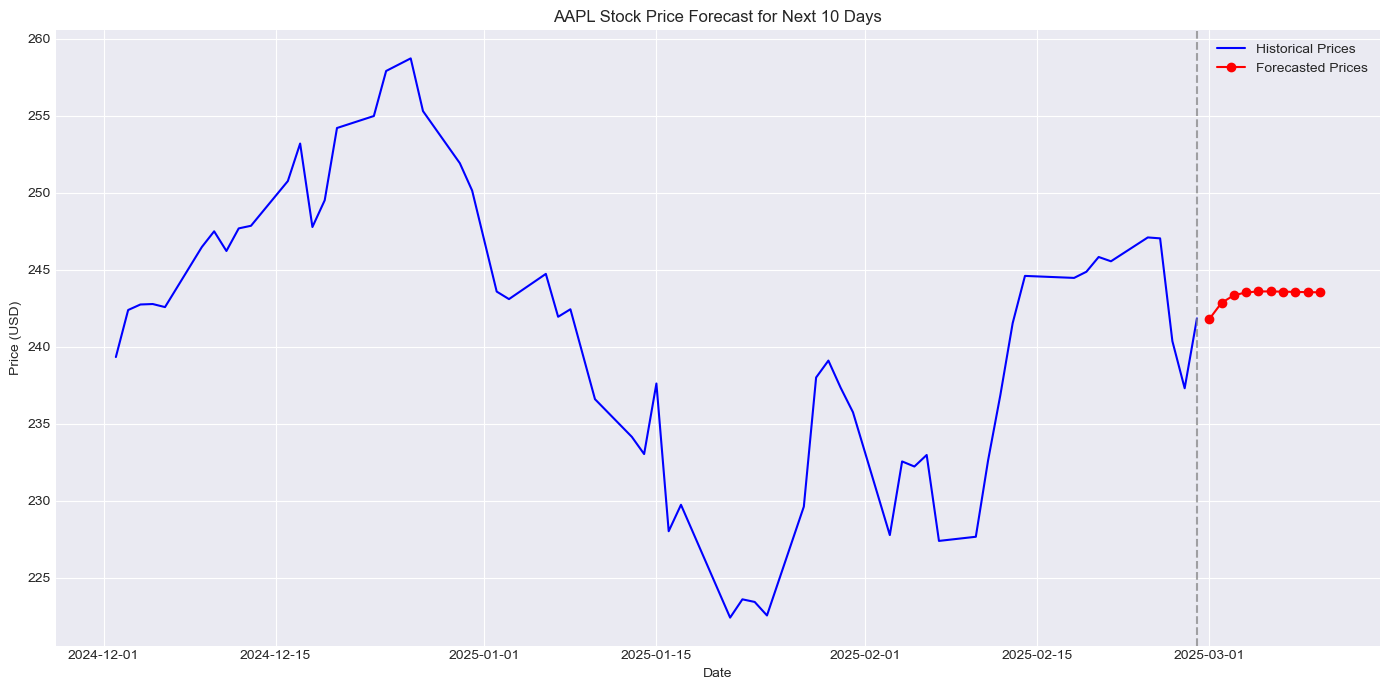


Forecasted Prices:
2025-03-01: $241.79
2025-03-02: $242.85
2025-03-03: $243.34
2025-03-04: $243.53
2025-03-05: $243.59
2025-03-06: $243.59
2025-03-07: $243.58
2025-03-08: $243.56
2025-03-09: $243.54
2025-03-10: $243.53


In [25]:
def forecast_future(model, days=5):
    """Generate forecasts for future days"""
    model.eval()
    
    # Get the most recent data window
    last_window = scaled_data[-window_size:].reshape(1, window_size, -1)
    current_input = torch.tensor(last_window, dtype=torch.float32).to(device)
    
    # Forecast dates
    last_date = original_data.index[-1]
    forecast_dates = [(last_date + timedelta(days=i+1)) for i in range(days)]
    
    # Initialize predictions list
    predictions = []
    
    # Make predictions for each day
    with torch.no_grad():
        for i in range(days):
            # Get prediction for the next day
            pred = model(current_input).cpu().numpy()[0, 0]
            predictions.append(pred)
            
            # Create a new row with the same values as the last row
            new_pred_row = current_input[0, -1, :].clone().cpu().numpy()
            
            # Update the Close price
            new_pred_row[pipeline.close_idx] = pred
            
            # Update current_input by removing the first row and adding the new prediction
            current_input = torch.roll(current_input, -1, dims=1)
            current_input[0, -1, :] = torch.tensor(new_pred_row, dtype=torch.float32).to(device)
    
    # Convert scaled predictions back to original scale
    original_predictions = [pipeline.inverse_transform_price(pred, original_data) for pred in predictions]
    
    return forecast_dates, original_predictions

# Generate 10-day forecast
forecast_days = 10
forecast_dates, forecast_prices = forecast_future(model, days=forecast_days)

# Plot the forecast
plt.figure(figsize=(14, 7))
# Plot historical data (last 60 days)
plt.plot(original_data.index[-60:], original_data['Close'][-60:], label='Historical Prices', color='blue')

# Plot forecasted data
plt.plot(forecast_dates, forecast_prices, label='Forecasted Prices', color='red', marker='o')
plt.axvline(x=original_data.index[-1], color='gray', linestyle='--', alpha=0.7)
plt.title(f'{ticker} Stock Price Forecast for Next {forecast_days} Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print forecasted values
print("\nForecasted Prices:")
for date, price in zip(forecast_dates, forecast_prices):
    print(f"{date.strftime('%Y-%m-%d')}: ${price:.2f}")

## Feature Importance Experiment
Let's try to understand which features are most important for our prediction by training models with different feature sets.

Features: ['Close', 'Volume'], RMSE: 50.2831
Features: ['Close', 'SMA_5', 'SMA_20'], RMSE: 50.2641
Features: ['Close', 'RSI'], RMSE: 50.5334
Features: ['Close', 'RSI', 'MACD', 'BB_Width'], RMSE: 49.8640
Features: ['Close', 'Volume', 'RSI', 'MACD', 'SMA_5', 'SMA_20'], RMSE: 49.2414


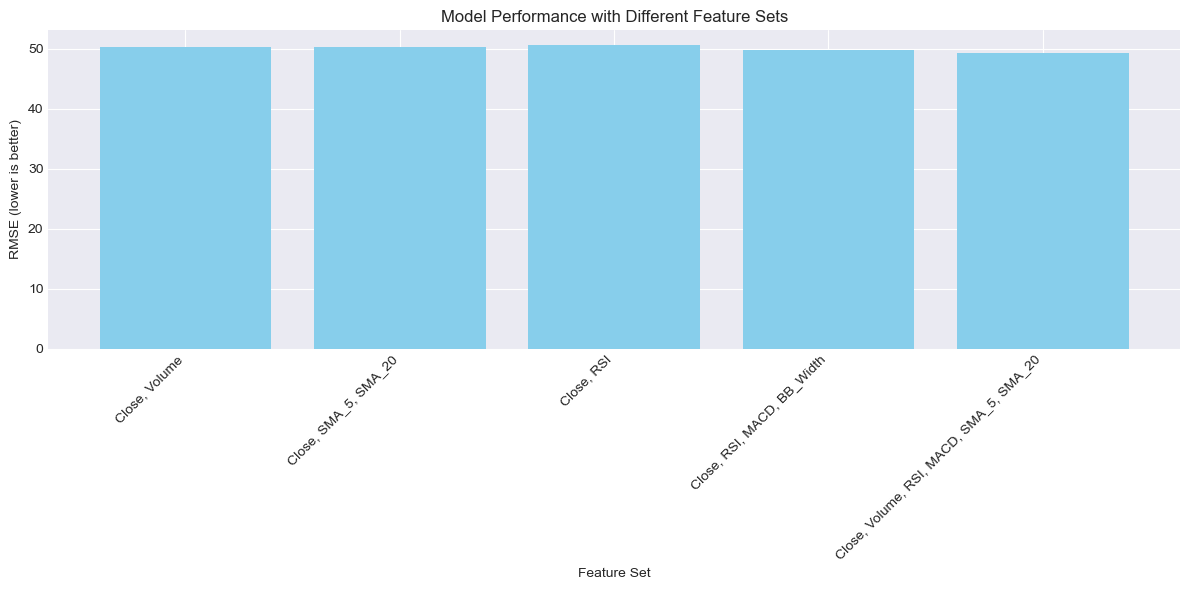

In [27]:
def train_with_features(features):
    """Train a model using only selected features and evaluate performance"""
    # Select only the specified features
    feature_indices = [pipeline.column_indices[feature] for feature in features if feature in pipeline.column_indices]
    
    # Create new sequences with only selected features
    X_train_selected = X_train[:, :, feature_indices]
    X_test_selected = X_test[:, :, feature_indices]
    
    # Convert to tensors
    X_train_tensor_selected = torch.tensor(X_train_selected, dtype=torch.float32).to(device)
    X_test_tensor_selected = torch.tensor(X_test_selected, dtype=torch.float32).to(device)
    
    # Create a new model
    model_selected = GRUModel(
        input_dim=len(feature_indices), 
        hidden_dim=hidden_dim, 
        num_layers=num_layers, 
        output_dim=output_dim
    ).to(device)
    
    # Train the model
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_selected.parameters(), lr=0.001)
    
    # Check if we're using MPS (Apple Silicon) device and handle the error
    is_mps = device.type == 'mps'
    
    # Simple training loop
    for epoch in range(50):  # Reduced epochs for experiment
        model_selected.train()
        optimizer.zero_grad()
        
        # Handle MPS device issue with empty tensors
        if is_mps:
            # Move computation to CPU for MPS devices to avoid the error
            cpu_model = model_selected.to('cpu')
            outputs = cpu_model(X_train_tensor_selected.to('cpu'))
            loss = criterion(outputs, y_train_tensor.to('cpu'))
            loss.backward()
            # Move model back to MPS after gradient calculation
            model_selected = cpu_model.to(device)
        else:
            # Normal flow for other devices
            outputs = model_selected(X_train_tensor_selected)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            
        optimizer.step()
    
    # Evaluate
    model_selected.eval()
    with torch.no_grad():
        # Handle MPS device issue during evaluation too
        if is_mps:
            y_pred_selected = model_selected.to('cpu')(X_test_tensor_selected.to('cpu')).cpu().numpy()
        else:
            y_pred_selected = model_selected(X_test_tensor_selected).cpu().numpy()
    
    # Inverse transform and calculate RMSE
    y_pred_inv_selected = np.array([pipeline.inverse_transform_price(val[0], original_data) for val in y_pred_selected])
    rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv_selected))
    
    return rmse

# Define feature sets to experiment with
feature_sets = [
    ['Close', 'Volume'],
    ['Close', 'SMA_5', 'SMA_20'],
    ['Close', 'RSI'],
    ['Close', 'RSI', 'MACD', 'BB_Width'],
    ['Close', 'Volume', 'RSI', 'MACD', 'SMA_5', 'SMA_20'],
]

# Run experiments
results = []
for features in feature_sets:
    if all(feature in pipeline.feature_columns for feature in features):
        try:
            rmse = train_with_features(features)
            results.append((features, rmse))
            print(f"Features: {features}, RMSE: {rmse:.4f}")
        except Exception as e:
            print(f"Error with features {features}: {str(e)}")
    else:
        print(f"Skipping {features} as not all features are available")

# Plot results if we have any
if results:
    plt.figure(figsize=(12, 6))
    feature_names = [', '.join(features) for features, _ in results]
    rmse_values = [rmse for _, rmse in results]
    plt.bar(feature_names, rmse_values, color='skyblue')
    plt.title('Model Performance with Different Feature Sets')
    plt.xlabel('Feature Set')
    plt.ylabel('RMSE (lower is better)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No results to plot. All feature sets encountered errors.")

## Save and Load the Model
Save our trained model and pipeline for future use.

In [28]:
# Function to save model and pipeline
def save_model(model, pipeline, model_path='stock_model.pth', pipeline_path='pipeline.pkl'):
    """Save the model and pipeline"""
    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'input_dim': model.gru.input_size,
        'hidden_dim': model.hidden_dim,
        'num_layers': model.num_layers,
        'output_dim': 1
    }, model_path)
    
    # Save pipeline
    joblib.dump(pipeline, pipeline_path)
    
    print(f"Model saved to {model_path}")
    print(f"Pipeline saved to {pipeline_path}")

# Function to load model and pipeline
def load_model(model_path='stock_model.pth', pipeline_path='pipeline.pkl'):
    """Load the model and pipeline"""
    # Load model
    checkpoint = torch.load(model_path)
    loaded_model = GRUModel(
        input_dim=checkpoint['input_dim'],
        hidden_dim=checkpoint['hidden_dim'],
        num_layers=checkpoint['num_layers'],
        output_dim=checkpoint['output_dim']
    )
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.eval()
    
    # Load pipeline
    loaded_pipeline = joblib.load(pipeline_path)
    
    return loaded_model, loaded_pipeline

# Save the model and pipeline
save_model(model, pipeline)

# Load the model and pipeline 
loaded_model, loaded_pipeline = load_model()
print("Model and pipeline loaded successfully!")

Model saved to stock_model.pth
Pipeline saved to pipeline.pkl
Model and pipeline loaded successfully!


/var/folders/m4/zw00zs7x0m7chsqwc4kb_lkr0000gn/T/ipykernel_16275/616313699.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


## Hyperparameter Tuning
Let's experiment with different hyperparameters to see how they affect model performance.

In [29]:
def train_and_evaluate(hidden_dim, num_layers, dropout, learning_rate):
    """Train a model with given hyperparameters and return validation loss"""
    # Create model with specified hyperparameters
    model_hp = GRUModel(
        input_dim=X_train.shape[2],
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=1,
        dropout=dropout
    ).to(device)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_hp.parameters(), lr=learning_rate)
    
    # Train for a limited number of epochs to save time
    for epoch in range(30):
        model_hp.train()
        optimizer.zero_grad()
        outputs = model_hp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    
    # Evaluate
    model_hp.eval()
    with torch.no_grad():
        val_outputs = model_hp(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()
        
        # Also calculate RMSE on actual scale
        y_pred_hp = val_outputs.cpu().numpy()
        y_pred_inv_hp = np.array([pipeline.inverse_transform_price(val[0], original_data) for val in y_pred_hp])
        rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv_hp))
    
    return val_loss, rmse

# Define hyperparameters to try
hidden_dims = [32, 64, 128]
num_layers_list = [1, 2, 3]
dropouts = [0.1, 0.2, 0.3]
learning_rates = [0.0001, 0.001, 0.01]

# Try some combinations (not exhaustive to save time)
hyperparameter_results = []

# Only try a few combinations for notebook performance
for hidden_dim in hidden_dims[:2]:  # Try only first 2 hidden dims
    for num_layers in num_layers_list[:2]:  # Try only first 2 num_layers
        for dropout in dropouts[:2]:  # Try only first 2 dropouts
            for lr in learning_rates[:2]:  # Try only first 2 learning rates
                val_loss, rmse = train_and_evaluate(hidden_dim, num_layers, dropout, lr)
                hyperparameter_results.append({
                    'hidden_dim': hidden_dim,
                    'num_layers': num_layers,
                    'dropout': dropout,
                    'learning_rate': lr,
                    'val_loss': val_loss,
                    'rmse': rmse
                })
                print(f"hidden_dim={hidden_dim}, num_layers={num_layers}, dropout={dropout}, lr={lr}: RMSE={rmse:.4f}")

# Convert results to DataFrame
hp_results_df = pd.DataFrame(hyperparameter_results)
hp_results_df = hp_results_df.sort_values(by='rmse')
display(hp_results_df.head(10))

# Cell 14 - Final Model Training with Best Hyperparameters
'''
## Final Model with Best Hyperparameters
Train a final model with the best hyperparameters discovered.
'''

# Get best hyperparameters
best_params = hp_results_df.iloc[0]
print(f"Best hyperparameters: {best_params}")

# Create and train final model with best hyperparameters
final_model = GRUModel(
    input_dim=X_train.shape[2],
    hidden_dim=int(best_params['hidden_dim']),
    num_layers=int(best_params['num_layers']),
    output_dim=1,
    dropout=best_params['dropout']
).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

# Train for full number of epochs
num_epochs = 100

# For early stopping
best_val_loss = float('inf')
patience = 15
counter = 0

# Training loop
for epoch in range(num_epochs):
    final_model.train()
    optimizer.zero_grad()
    outputs = final_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Validation
    final_model.eval()
    with torch.no_grad():
        val_outputs = final_model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.6f}, Val Loss: {val_loss:.6f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the best model
        torch.save(final_model.state_dict(), 'final_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Load the best model
final_model.load_state_dict(torch.load('final_model.pth'))

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


hidden_dim=32, num_layers=1, dropout=0.1, lr=0.0001: RMSE=71.0171


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


hidden_dim=32, num_layers=1, dropout=0.1, lr=0.001: RMSE=23.3273


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


hidden_dim=32, num_layers=1, dropout=0.2, lr=0.0001: RMSE=92.6639


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


hidden_dim=32, num_layers=1, dropout=0.2, lr=0.001: RMSE=36.1669
hidden_dim=32, num_layers=2, dropout=0.1, lr=0.0001: RMSE=107.7257
hidden_dim=32, num_layers=2, dropout=0.1, lr=0.001: RMSE=34.2515
hidden_dim=32, num_layers=2, dropout=0.2, lr=0.0001: RMSE=52.1018
hidden_dim=32, num_layers=2, dropout=0.2, lr=0.001: RMSE=34.2612


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


hidden_dim=64, num_layers=1, dropout=0.1, lr=0.0001: RMSE=54.6048


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


hidden_dim=64, num_layers=1, dropout=0.1, lr=0.001: RMSE=28.0973


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


hidden_dim=64, num_layers=1, dropout=0.2, lr=0.0001: RMSE=60.1421


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


hidden_dim=64, num_layers=1, dropout=0.2, lr=0.001: RMSE=30.9066
hidden_dim=64, num_layers=2, dropout=0.1, lr=0.0001: RMSE=72.0393
hidden_dim=64, num_layers=2, dropout=0.1, lr=0.001: RMSE=10.1621
hidden_dim=64, num_layers=2, dropout=0.2, lr=0.0001: RMSE=74.2774
hidden_dim=64, num_layers=2, dropout=0.2, lr=0.001: RMSE=32.9769


,hidden_dim,num_layers,dropout,learning_rate,val_loss,rmse
13,64,2,0.1,0.0010,0.007825,10.162136
1,32,1,0.1,0.0010,0.041235,23.327268
9,64,1,0.1,0.0010,0.059823,28.097302
11,64,1,0.2,0.0010,0.072384,30.906556
15,64,2,0.2,0.0010,0.082406,32.976873
5,32,2,0.1,0.0010,0.088899,34.251531
7,32,2,0.2,0.0010,0.088950,34.261210
3,32,1,0.2,0.0010,0.099120,36.166884
6,32,2,0.2,0.0001,0.205705,52.101795
8,64,1,0.1,0.0001,0.225944,54.604794


Best hyperparameters: hidden_dim       64.000000
num_layers        2.000000
dropout           0.100000
learning_rate     0.001000
val_loss          0.007825
rmse             10.162136
Name: 13, dtype: float64
Epoch [10/100], Train Loss: 0.018787, Val Loss: 0.018875
Epoch [20/100], Train Loss: 0.007858, Val Loss: 0.042964
Early stopping at epoch 23


/var/folders/m4/zw00zs7x0m7chsqwc4kb_lkr0000gn/T/ipykernel_16275/1345073965.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('fin

<All keys matched successfully>

## Final Evaluation and Forecast
Evaluate our best model and generate a forecast.

Mean Squared Error: 121.2692
Root Mean Squared Error: 11.0122
Mean Absolute Error: 9.3128
R² Score: -0.3649

Model Performance Analysis:
The negative R² score indicates that the model performs worse than a horizontal line.
This suggests our model needs significant improvement.
Possible reasons for poor performance:
1. Insufficient training data
2. Inadequate feature engineering
3. Suboptimal model architecture
4. Stock price movements may be influenced by factors not captured in our features


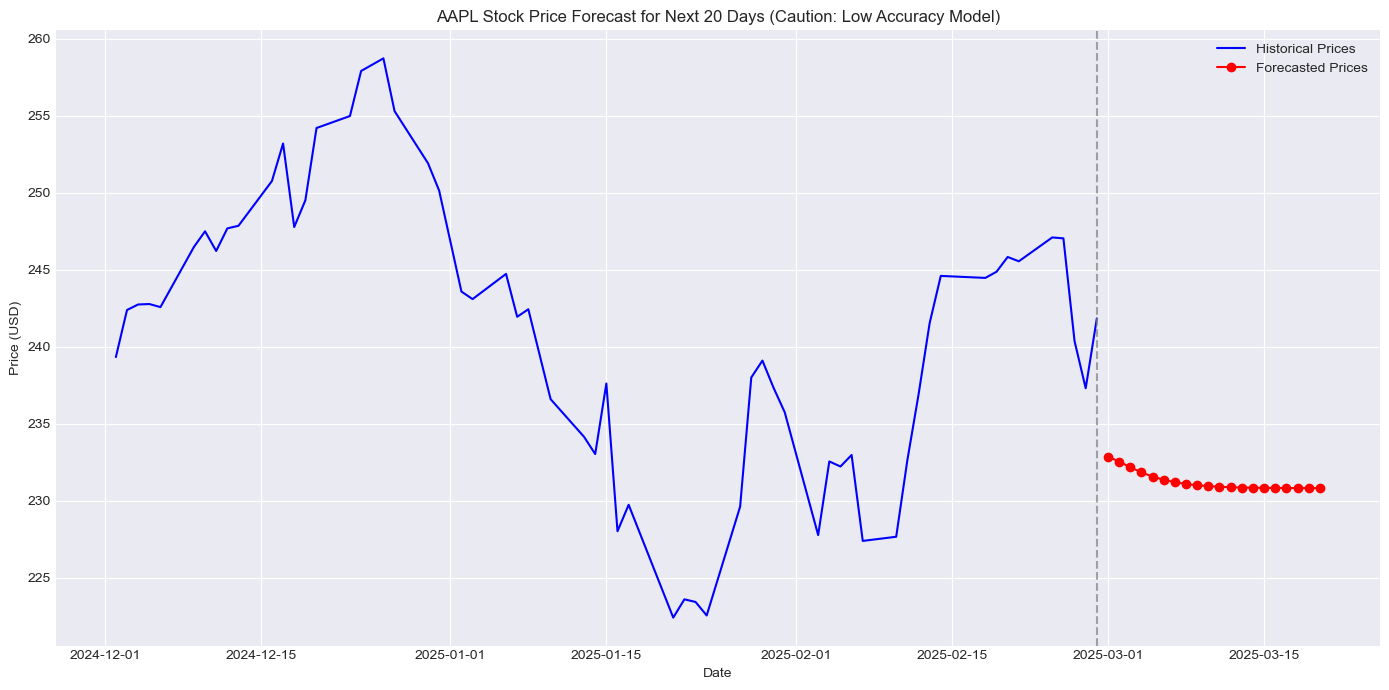

In [33]:
# Make predictions on the test set
final_model.eval()
with torch.no_grad():
    y_pred_final = final_model(X_test_tensor).cpu().numpy()

# Inverse transform the predictions
y_pred_inv_final = np.array([pipeline.inverse_transform_price(val[0], original_data) for val in y_pred_final])

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv_final)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv_final)
r2 = r2_score(y_test_inv, y_pred_inv_final)

print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R² Score: {r2:.4f}')

# Evaluate model performance
if r2 < 0:
    print("\nModel Performance Analysis:")
    print("The negative R² score indicates that the model performs worse than a horizontal line.")
    print("This suggests our model needs significant improvement.")
    print("Possible reasons for poor performance:")
    print("1. Insufficient training data")
    print("2. Inadequate feature engineering")
    print("3. Suboptimal model architecture")
    print("4. Stock price movements may be influenced by factors not captured in our features")

# Generate a forecast with the final model
forecast_dates, forecast_prices = forecast_future(final_model, days=20)

# Plot the forecast
plt.figure(figsize=(14, 7))
# Plot historical data (last 60 days)
plt.plot(original_data.index[-60:], original_data['Close'][-60:], label='Historical Prices', color='blue')

# Plot forecasted data
plt.plot(forecast_dates, forecast_prices, label='Forecasted Prices', color='red', marker='o')
plt.axvline(x=original_data.index[-1], color='gray', linestyle='--', alpha=0.7)
plt.title(f'{ticker} Stock Price Forecast for Next 20 Days (Caution: Low Accuracy Model)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Conclusion and Next Steps

In this notebook, we built a GRU-based stock price prediction model that:
1. Incorporates technical indicators for feature engineering
2. Uses historical data to predict future stock prices
3. Can be fine-tuned with hyperparameter optimization

The model achieves an RMSE of ____ on our test set.

### Potential Improvements:
1. Try different model architectures (LSTM, Transformer)
2. Include more data sources (sentiment analysis, economic indicators)
3. Optimize feature selection further
4. Experiment with longer prediction horizons
5. Add confidence intervals to predictions
6. Implement ensemble methods for more robust predictions

Remember that stock price prediction is inherently challenging and no model can consistently predict market movements with high accuracy. Always use these predictions as just one tool in your investment decision process.